In [1]:
## From: https://towardsdatascience.com/web-scraping-craigslist-a-complete-tutorial-c41cea4f4981

#import get to call a get request on the site
from requests import get

#get the first page of the housing prices
response = get('https://minneapolis.craigslist.org/search/apa?hasPic=1&availabilityMode=0') #get rid of those lame-o's that post a housing option without a pic using their filter

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print( len(posts)) #to double check I got 120 (elements/page)
post = posts[0]

<class 'bs4.element.ResultSet'>
120


In [2]:
curtime = post.find('time',class_='result-date')['datetime']
print(curtime)
cururl = post.find('a',class_='result-title hdrlnk')['href']
print(cururl)

2020-07-13 19:04
https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-granite-countertops/7155250059.html


In [3]:
#curbrs = post.find('span', class_ = 'housing').text.split()[0][:-2]
#print(curbrs)

#cursqft = post.find('span', class_ = 'housing')
#if cursqft:
#    cursqft = cursqft.text.split()[2][:-3] #cleans the ft2 at the end
#    print(cursqft)
#print(cursqft)

curhood = post.find('span', class_='result-hood') 
if curhood:
    curhood = curhood.text
    print(curhood)



In [4]:
from geopy.geocoders import Nominatim, ArcGIS
curmap = BeautifulSoup(get(cururl).text,'html.parser').find_all('div',class_='mapbox')[0]
geolocator = Nominatim(user_agent="darren")

print(curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])

location = geolocator.reverse(query=curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])


geolocator2 = ArcGIS(user_agent="darren")
location2 = geolocator2.reverse(query=curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'],
                                distance=500)





import numpy as np

loc = geolocator.reverse(query=str(np.round(float(curmap.find('div')['data-latitude'])-.001,3))
                   +","
                   +str(np.round(float(curmap.find('div')['data-longitude'])-.001,3)))
    
print(location.address)
print(location2.address)
print(loc.address)

#print(location.raw['address'])
#print(location.raw['address']['city'])
#print(location.raw['address']['neighbourhood'])
#print(location.raw['address']['postcode'])

44.865132,-93.308665
7600, Penn Avenue South, Richfield, Hennepin County, Minnesota, 55423, United States of America
Penn Ave S, Minneapolis, Minnesota 55423, USA
7700, Penn Avenue South, Richfield, Hennepin County, Minnesota, 55423, United States of America


In [5]:
curpost = get(post.find('a', class_='result-title hdrlnk')['href']).text
curmap = BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')
print(curmap)

[<div class="mapbox">
<div class="viewposting" data-accuracy="5" data-latitude="44.865132" data-longitude="-93.308665" id="map"></div>
<div class="mapaddress">7620 Penn Ave S</div>
<p class="mapaddress">
<small>
            (<a href="https://www.google.com/maps/search/44.865132,-93.308665" target="_blank">google map</a>)
        </small>
</p>
</div>]


In [6]:
#new code to put here:
#get list of neighborhoods
#for each neighborhood,
#  get central coordinate
#for each posting
#  calculate distance from neighborhoods' centers
#  assign neighborhood based on nearest neighbor

In [7]:
#linkpfx = 'https://minneapolis.craigslist.org/search/apa?'
#linksfx =( 'sort=date'
#          +'&hasPic=1'
#          +'&bundleDuplicates=1'
#          +'&search_distance=20'
#          +'&postal=55454'
#          +'&min_price=500'
#          +'&max_price=4000'
#          +'&max_bedrooms=3'
#          +'&availabilityMode=0'
#          +'&sale_date=all+dates')
#response = get(linkpfx+linksfx)
#html_soup = BeautifulSoup(response.text, 'html.parser')
#results_num = html_soup.find('div', class_= 'search-legend')
#results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array
#pages = np.arange(0, results_total+1, 120)
#print(results_total)
#print(pages)

#post.find('a', class_='result-title hdrlnk')['href'] in post_links
#post.find('a', class_='result-title hdrlnk')['href'] in 
#apts['URL'].str.contains(post.find('a', class_='result-title hdrlnk')['href']).sum()
#apts['URL'].str.contains('https://minneapolis.craigslist.org/dak/apa/d/burnsville-end-unit-2-bedroom-townhouse/7135839874.html').sum()

In [8]:
#build out the loop
from bs4 import BeautifulSoup
from time import sleep, time
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from IPython.core.display import clear_output
import numpy as np


citystr = 'minneapolis' ## 'washingtondc' #'minneapolis'
linkpfx = 'https://'+citystr+'.craigslist.org/search/apa?'
linksfx =( 'sort=date'
          +'&hasPic=1'
          +'&bundleDuplicates=1'
          +'&search_distance=20'
          +'&postal=55454' #55454' #DC: 20009
          +'&min_price=300'
          +'&max_price=8000'
          +'&max_bedrooms=4'
          +'&availabilityMode=0'
          +'&sale_date=all+dates')
response = get(linkpfx+linksfx)
html_soup = BeautifulSoup(response.text, 'html.parser')
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array
pages = np.arange(0, results_total+1, 120)


from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="derinkuyu",timeout=5)

#
TypeDict = {
    'apartment': 1, 
    'condo':2, 
    'cottage/cabin':3, 
    'duplex':4, 
    'flat':5, 
    'house':6, 
    'in-law':7, 
    'loft':8, 
    'townhouse':9, 
    'manufactured':10, 
    'assisted living':11, 
    'land':12}
LaundryDict = {
    'w/d in unit':1,
    'w/d hookups':2,
    'laundry in bldg':3,
    'laundry on site':4,
    'no laundry on site':5
}    
ParkingDict = {
    'carport':1,
    'attached garage':2,
    'detached garage':3,
    'off-street parking':4,
    'street parking':5,
    'valet parking':6,
    'no parking':7
}

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []


cities = []
towns = []
neighborhoods = []
zips = []


types = []
laundries = []
parkings = []

for page in pages:
    
    #get request
    response = get(linkpfx
                   + 's=' #parameter for defining page number
                   + str(page) #page in above array
                   + linksfx)    
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:
        
        curpost = get(post.find('a', class_='result-title hdrlnk')['href']).text
        curmap = BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')
        
        if (post.find('span', class_ = 'result-hood') is not None) and curmap and (
        post.find('a', class_='result-title hdrlnk')['href'] not in post_links):

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #
            #curpost = get(post_link).text
            curmap = curmap[0] #BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')[0]
            location = geolocator.reverse(curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])
            
            try: 
                cities.append(location.raw['address']['city'])
            except:
                try: 
                    cities.append(location.raw['address']['town'])
                except:
                    cities.append('')
            
            try: 
                towns.append(location.raw['address']['town'])
            except:
                towns.append('')
            
            try:
                neighborhoods.append(location.raw['address']['neighbourhood'])
            except:
                try: 
                    locshift1 = geolocator.reverse( str(float(curmap.find('div')['data-latitude'])+.001)+","+str(float(curmap.find('div')['data-longitude'])+.001))
                    neighborhoods.append(locshift1.raw['address']['neighbourhood'])
                except:                   
                    try: 
                        locshift2 = geolocator.reverse( str(float(curmap.find('div')['data-latitude'])-.001)+","+str(float(curmap.find('div')['data-longitude'])-.001))
                        neighborhoods.append(locshift2.raw['address']['neighbourhood'])
                    except:
                        try:
                            neighborhoods.append(location.raw['address']['town'])
                        except:
                            try:
                                neighborhoods.append(location.raw['address']['city'])
                            except:
                                neighborhoods.append('')
            
            try:
                zips.append(location.raw['address']['postcode'])
            except:
                zips.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                typename = list(set(curattr.text.split('\n')).intersection(list(TypeDict.keys())))[0]
                types.append(TypeDict[typename])
            except:
                types.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                laundryname = list(set(curattr.text.split('\n')).intersection(list(LaundryDict.keys())))[0]
                laundries.append(LaundryDict[laundryname])
            except:
                laundries.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                parkname = list(set(curattr.text.split('\n')).intersection(list(ParkingDict.keys())))[0]
                parkings.append(ParkingDict[parkname])
            except:
                parkings.append('')
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            post_price = int(post.a.text.strip().replace("$", "")) 
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

import pandas as pd

apts = pd.DataFrame({
    'posted': post_timing,
    'neighborhood': post_hoods,
    'post title': post_title_texts,
    'number bedrooms': bedroom_counts,
    'sqft': sqfts,
    'URL': post_links,
    'price': post_prices,
    'cities':cities,
    'towns':towns,
    'neighborhoods':neighborhoods,
    'zips': zips,
    'types':types,
    'parking':parkings,
    'laundry':laundries})
#print(apts.info())
#apts.head(30)
apts.shape

#drop duplicates
apts = apts.drop_duplicates(subset=['URL','sqft','number bedrooms'])

#make the number bedrooms to a float (since np.nan is a float too)
apts['number bedrooms'] = apts['number bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to be able to work with it
from datetime import datetime

apts['posted'] = pd.to_datetime(apts['posted'])

#Looking at what neighborhoods there are with apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

##remove the parenthesis from the left and right of the neighborhoods
#apts['neighborhood'] = apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))
#
##titlecase them
#apts['neighborhood'] = apts['neighborhood'].str.title()
#
##just take the first name of the neighborhood list, splitting on the '/' delimiter
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.split('/')[0])
#
##fix one-offs that
#apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
#apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)
#
##remove whitespaces
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.strip())

#save the clean data

apts.to_csv(path_or_buf='./scraped_data/apts_'+citystr+"_"+str(datetime.now()).replace(' ','_').replace(':','-')+'.csv', index=False)
apts.shape


Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!
Page 9 scraped successfully!
Page 10 scraped successfully!
Page 11 scraped successfully!
Page 12 scraped successfully!
Page 13 scraped successfully!
Page 14 scraped successfully!
Page 15 scraped successfully!
Page 16 scraped successfully!
Page 17 scraped successfully!
Page 18 scraped successfully!
Page 19 scraped successfully!
Page 20 scraped successfully!
Page 21 scraped successfully!
Page 22 scraped successfully!
Page 23 scraped successfully!
Page 24 scraped successfully!
Page 25 scraped successfully!
Page 26 scraped successfully!


Scrape complete!


(97, 14)

In [9]:
##drop duplicates
#apts = apts.drop_duplicates(subset=['URL','sqft','number bedrooms'])
#
##make the number bedrooms to a float (since np.nan is a float too)
#apts['number bedrooms'] = apts['number bedrooms'].apply(lambda x: float(x))
#
##convert datetime string into datetime object to be able to work with it
#from datetime import datetime
#
#apts['posted'] = pd.to_datetime(apts['posted'])

#Looking at what neighborhoods there are with apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

##remove the parenthesis from the left and right of the neighborhoods
#apts['neighborhood'] = apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))
#
##titlecase them
#apts['neighborhood'] = apts['neighborhood'].str.title()
#
##just take the first name of the neighborhood list, splitting on the '/' delimiter
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.split('/')[0])
#
##fix one-offs that
#apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
#apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)
#
##remove whitespaces
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.strip())

#save the clean data

#apts.to_csv(path_or_buf='./apts_'+str(datetime.now()).replace(' ','_').replace(':','-')+'.csv', index=False)
#apts.shape

In [10]:
import os
import glob
citystr = 'minneapolis' #'minneapolis', 'washingtondc'

aptfiles = glob.glob('./scraped_data/apts_'+citystr+'*')


try:
    del apts
except:
    print('no apts in memory, loading some...')


for file in aptfiles:
    try: 
        apts = apts.append(pd.read_csv(file),ignore_index=True)
    except:
        apts = pd.read_csv(file)
#apts = apts.drop_duplicates(subset=['URL','sqft','number bedrooms'])
apts = apts.drop_duplicates(subset=['price','sqft','number bedrooms','laundry','parking','zips','types','neighborhoods'])
apts = apts[apts['sqft']<2000]
apts = apts[apts['price']>559]
apts = apts[apts['price']<2500]
apts = apts[apts['price'] / apts['number bedrooms'] > 400]

print(str(apts.shape[0])+' unique listings found.')

2901 unique listings found.


In [11]:
from operator import itemgetter
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=False)
apt = apts.iloc[0]
zipcode = search.by_zipcode(str(apt['zips']))
zipDict = zipcode.to_dict()
NaN = np.nan
if 'medianIncome' not in apts.columns:
    apts['medianIncome'] = NaN
    apts = pd.concat([apts,pd.DataFrame(columns=list(map(itemgetter('x'), zipDict['population_by_age'][2]['values'])))])

print(apts.columns)

Index(['posted', 'neighborhood', 'post title', 'number bedrooms', 'sqft',
       'URL', 'price', 'cities', 'towns', 'neighborhoods', 'zips', 'types',
       'parking', 'laundry', 'medianIncome', 'Under 5', '5-9', '10-14',
       '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54',
       '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85 Plus'],
      dtype='object')


In [12]:

#index = 0
#apt = apts.iloc[index]
#zipcode = search.by_zipcode(str(apt['zips']))
#zipDict = zipcode.to_dict()
#income = np.float(zipDict['median_household_income'])
#popsByAge = np.array(list(map(itemgetter('y'), zipDict['population_by_age'][2]['values'] )) ) / zipDict['population']
#
#apts.loc[index,'medianIncome'] = income
#apts.loc[index,list(map(itemgetter('x'), zipDict['population_by_age'][2]['values']))] = popsByAge
#print(apts.iloc[0])
#
    

    
for index, apt in apts.iterrows():
    zipcode = search.by_zipcode(str(apt['zips']))
    zipDict = zipcode.to_dict()
    income = zipDict['median_household_income']
    if income is not None:
        apts.loc[index,'medianIncome'] = np.float(income)
        
    if zipDict['population_by_age'] is not None:
        popsByAge = list(map(itemgetter('y'), zipDict['population_by_age'][2]['values'] ))
        apts.loc[index,list(map(itemgetter('x'), zipDict['population_by_age'][2]['values']))] = np.array(popsByAge) / zipDict['population']

apts['pKids'] = apts[['Under 5', '5-9', '10-14']].sum(axis=1)
apts['pYouths'] = apts[['15-19']].sum(axis=1)
apts['pEarlyTwenties'] = apts[['20-24']].sum(axis=1)
apts['pLateTwenties'] = apts[['25-29']].sum(axis=1)
apts['pEarlyThirties'] = apts[['30-34']].sum(axis=1)
apts['pLateThirties'] = apts[['35-39']].sum(axis=1)
apts['pEarlyForties'] = apts[['40-44']].sum(axis=1)
apts['pLateForties'] = apts[['45-49']].sum(axis=1)
apts['pFifties'] = apts[['50-54','55-59']].sum(axis=1)
apts['pSixtyPlus'] = apts[['60-64','65-69','70-74','75-79','80-84','85 Plus']].sum(axis=1)

In [13]:
#from walkscore import WalkScoreAPI
#api_key = 'YOUR API KEY GOES HERE'
#
#walkscore_api = WalkScoreAPI(api_key = api_key)

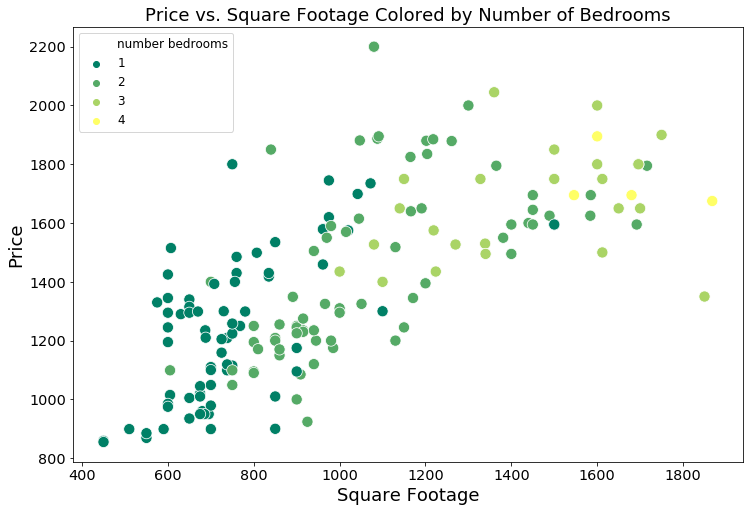

In [14]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.scatterplot(x='sqft', y='price', hue='number bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Square Footage", fontsize=18)
plt.ylabel("Price", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);


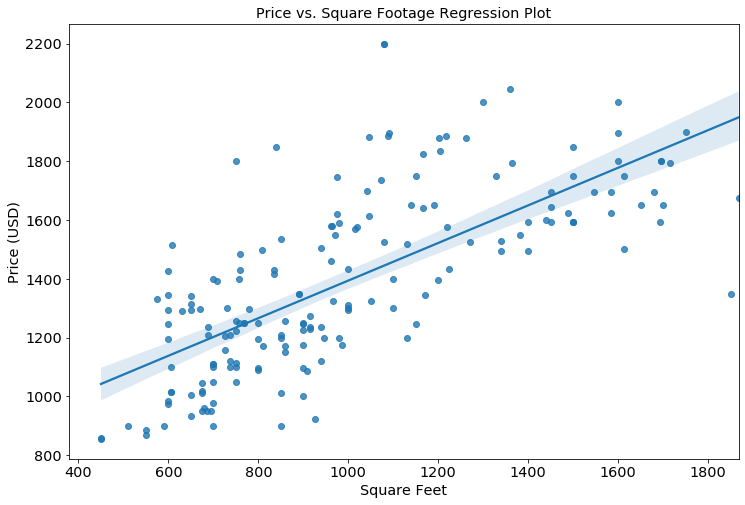

In [15]:
plt.figure(figsize=(12, 8))
sns.regplot(x='sqft', y='price', data=apts.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Square Feet");
plt.ylabel("Price (USD)");

In [16]:
apts.corr()

number bedrooms      sqft     price     types   parking  \
number bedrooms         1.000000  0.789544  0.494093  0.373627  0.052438   
sqft                    0.789544  1.000000  0.596824  0.482845 -0.119676   
price                   0.494093  0.596824  1.000000  0.197784 -0.383237   
types                   0.373627  0.482845  0.197784  1.000000 -0.090477   
parking                 0.052438 -0.119676 -0.383237 -0.090477  1.000000   
laundry                -0.030910 -0.194715 -0.539627 -0.152523  0.588842   
medianIncome            0.047379  0.185369  0.093762  0.127716 -0.186046   
pKids                   0.108109  0.106290 -0.137750  0.133566  0.144661   
pYouths                 0.131968  0.041198 -0.110957  0.131584  0.153755   
pEarlyTwenties          0.012923 -0.105273  0.029098 -0.011217  0.101458   
pLateTwenties          -0.145569 -0.167544  0.152348 -0.120793 -0.027031   
pEarlyThirties         -0.123699 -0.133736  0.128795 -0.078114 -0.020019   
pLateThirties          -0.053570 -0.054360  0.061164  0.004483  0.016724   
pEarlyForties           0.007123  0.027247  0.022610  0.078340  0.019591   
pLateForties            0.028962  0.065659 -0.000196  0.104575 -0.018783   
pFifties                0.011711  0.051779  0.000814  0.075537 -0.017696   
pSixtyPlus             -0.032956  0.020314 -0.007496 -0.010856 -0.056054   

                  laundry  medianIncome     pKids   pYouths  pEarlyTwenties  \
number bedrooms -0.030910      0.047379  0.108109  0.131968        0.012923   
sqft            -0.194715      0.185369  0.106290  0.041198       -0.105273   
price           -0.539627      0.093762 -0.137750 -0.110957        0.029098   
types           -0.152523      0.127716  0.133566  0.131584       -0.011217   
parking          0.588842     -0.186046  0.144661  0.153755        0.101458   
laundry          1.000000     -0.136962  0.091185  0.064143       -0.022150   
medianIncome    -0.136962      1.000000  0.311715 -0.008538       -0.568840   
pKids            0.091185      0.311715  1.000000  0.471084       -0.039809   
pYouths          0.064143     -0.008538  0.471084  1.000000        0.617175   
pEarlyTwenties  -0.022150     -0.568840 -0.039809  0.617175        1.000000   
pLateTwenties   -0.104567     -0.437142  0.032837 -0.076232        0.478787   
pEarlyThirties  -0.104545     -0.265879  0.257461 -0.030465        0.340733   
pLateThirties   -0.078203      0.143954  0.601116  0.159222        0.210714   
pEarlyForties   -0.065442      0.653038  0.768243  0.294700        0.090567   
pLateForties    -0.066944      0.727772  0.758965  0.340038       -0.002111   
pFifties        -0.057337      0.649190  0.694687  0.324217        0.005126   
pSixtyPlus      -0.027956      0.210812  0.475785  0.184870       -0.037174   

                 pLateTwenties  pEarlyThirties  pLateThirties  pEarlyForties  \
number bedrooms      -0.145569       -0.123699      -0.053570       0.007123   
sqft                 -0.167544       -0.133736      -0.054360       0.027247   
price                 0.152348        0.128795       0.061164       0.022610   
types                -0.120793       -0.078114       0.004483       0.078340   
parking              -0.027031       -0.020019       0.016724       0.019591   
laundry              -0.104567       -0.104545      -0.078203      -0.065442   
medianIncome         -0.437142       -0.265879       0.143954       0.653038   
pKids                 0.032837        0.257461       0.601116       0.768243   
pYouths              -0.076232       -0.030465       0.159222       0.294700   
pEarlyTwenties        0.478787        0.340733       0.210714       0.090567   
pLateTwenties         1.000000        0.939410       0.729870       0.479173   
pEarlyThirties        0.939410        1.000000       0.894851       0.682103   
pLateThirties         0.729870        0.894851       1.000000       0.919938   
pEarlyForties         0.479173        0.682103       0.919938       1.000000   
pLateForties          0.2

In [17]:
apts[apts['number bedrooms']<=1].groupby('neighborhoods').median()

number bedrooms    sqft   price  types  parking  laundry  \
neighborhoods                                                             
Anoka                      1.0   735.0  1060.0    1.0      NaN      4.0   
Apple Valley               1.0   857.0  1277.0    1.0      2.0      1.0   
Aquila                     1.0   750.0  1000.0    1.0      3.0      3.0   
Audubon Park               1.0   800.0   890.0    2.0      2.0      3.0   
Autumn Woods               1.0  1342.0  1885.0    1.0      2.0      1.0   
...                        ...     ...     ...    ...      ...      ...   
Whittier                   1.0   560.0  1025.0    1.0      4.0      3.0   
Willow Park                1.0   715.0  1525.0    1.0      2.0      1.0   
Windom                     1.0   675.0   925.0    1.0      3.5      3.5   
Windom Park                1.0   535.0  1150.0    1.0      4.0      3.0   
Woodbury                   1.0   806.5  1424.5    5.0      2.0      1.0   

               medianIncome     pKids   pYouths  pEarlyTwenties  \
neighborhoods                                                     
Anoka               68130.0  0.214166  0.072597        0.058401   
Apple Valley        80378.0  0.206646  0.069188        0.052196   
Aquila              63699.0  0.159190  0.042854        0.067027   
Audubon Park        55486.0  0.172401  0.047740        0.063179   
Autumn Woods       102759.0  0.243626  0.077844        0.034343   
...                     ...       ...       ...             ...   
Whittier            43178.0  0.158134  0.041269        0.134118   
Willow Park         63699.0  0.159190  0.042854        0.067027   
Windom              94177.0  0.104919  0.025676        0.019617   
Windom Park         55486.0  0.172401  0.047740        0.063179   
Woodbury            99620.0  0.259517  0.064315        0.041386   

               pLateTwenties  pEarlyThirties  pLateThirties  pEarlyForties  \
neighborhoods                                                                
Anoka               0.067117        0.068692       0.070547       0.078055   
Apple Valley        0.066172        0.067863       0.066539       0.074260   
Aquila              0.124634        0.093606       0.064221       0.062538   
Audubon Park        0.097414        0.099281       0.080110       0.069999   
Autumn Woods        0.048704        0.051046       0.063690       0.091581   
...                      ...             ...            ...            ...   
Whittier            0.165920        0.101875       0.072026       0.062740   
Willow Park         0.124634        0.093606       0.064221       0.062538   
Windom              0.035958        0.039347       0.039536       0.042244   
Windom Park         0.097414        0.099281       0.080110       0.069999   
Woodbury            0.065057        0.072514       0.080194       0.088841   

               pLateForties  pFifties  pSixtyPlus  
neighborhoods                                      
Anoka              0.085541  0.136952    0.147933  
Apple Valley       0.085568  0.156833    0.154735  
Aquila             0.065785  0.124875    0.195270  
Audubon Park       0.070508  0.136061    0.163308  
Autumn Woods       0.111978  0.160423    0.116766  
...                     ...       ...         ...  
Whittier           0.055824  0.096235    0.104730  
Willow Park        0.065785  0.124875    0.195270  
Windom             0.039915  0.074055    0.078732  
Windom Park        0.070508  0.136061    0.163308  
Woodbury           0.084427  0.126645    0.117106  

[113 rows x 17 columns]

In [18]:
#apts[apts['number bedrooms']<=1].groupby('neighborhoods').median()['price'].sort_values()

In [19]:
#apts[apts['number bedrooms']<=brlim]['neighborhoods'].unique()

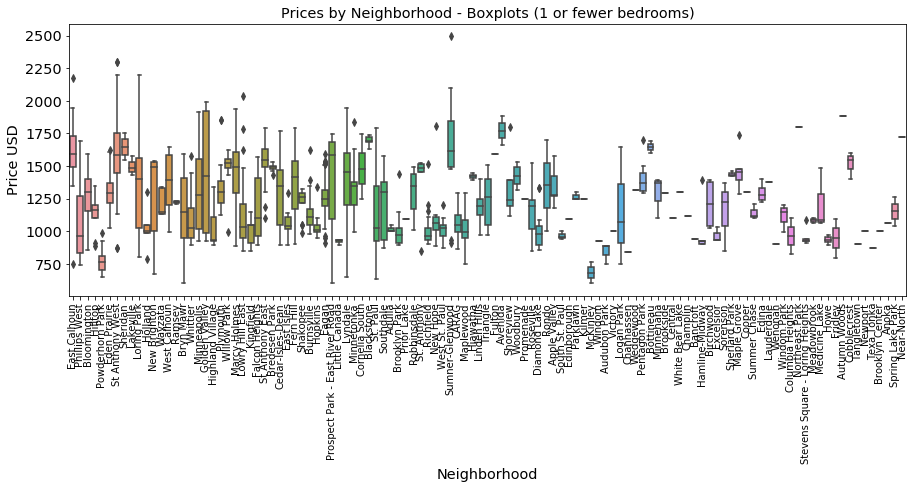

In [20]:
brlim = 1
sns.boxplot(x='neighborhoods', y='price', data=apts[apts['number bedrooms']<=brlim])
            #order=sorted(apts[apts['number bedrooms']<=brlim]['neighborhoods'].unique()))
plt.xlabel("Neighborhood");
plt.xticks(rotation=90,size=10)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots ("+str(brlim)+" or fewer bedrooms)");

In [21]:
# drop problematic cols
apts = apts.dropna(subset=['price','number bedrooms','sqft','neighborhoods','types','laundry','parking',
                           'medianIncome','pKids','pYouths','pEarlyTwenties','pLateTwenties',
                           'pEarlyThirties','pLateThirties','pEarlyForties','pLateForties','pFifties','pSixtyPlus'])
print(apts.shape)

# recode neighborhoods
apts_onehot = apts.copy()
apts_onehot = pd.get_dummies(apts_onehot, columns=['cities'], prefix = ['ct'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['neighborhoods'], prefix = ['nb'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['types'], prefix = ['ty'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['laundry'], prefix = ['ld'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['parking'], prefix = ['pk'])
apts_onehot['parking'] = apts['parking']
apts_onehot['laundry'] = apts['laundry']
apts_onehot['cities'] = apts['cities']

#print(apts_onehot)

(2299, 43)


In [22]:
from sklearn import preprocessing
from sklearn import linear_model

maincols = ['number bedrooms','sqft','medianIncome',
            'pKids','pYouths',
            'pEarlyTwenties','pLateTwenties',
            'pEarlyThirties','pLateThirties',
            'pEarlyForties','pLateForties',
            'pFifties','pSixtyPlus']
#nbcols = [col for col in apts_onehot if col.startswith('ct')]
#for c in nbcols:
#    maincols.append(c) 
nbcols = [col for col in apts_onehot if col.startswith('nb')]
for c in nbcols:
    maincols.append(c) 
tycols = [col for col in apts_onehot if col.startswith('ty')]
for c in tycols:
    maincols.append(c) 
pkcols = [col for col in apts_onehot if col.startswith('pk')]
for c in pkcols:
    maincols.append(c) 
ldcols = [col for col in apts_onehot if col.startswith('ld')]
for c in ldcols:
    maincols.append(c) 

# set up regression
y = apts_onehot['price'].values.reshape(-1,1)
X = apts_onehot[maincols].values
thresh = .5 # drop columns that correlate above this value
cor = np.abs(np.corrcoef(X.T))
p = np.argwhere(np.triu(np.isclose(cor,1),1))
X = np.delete(X,p[:,1],axis=1)
X = preprocessing.scale(X)
print("Number observations: "+str(X.shape[0]))

#OLS
reg = linear_model.LinearRegression()
reg.fit(y=y,X=X)
apts_onehot['price_est'] = np.zeros((apts_onehot.shape[0],1))
apts_onehot['price_est'] = reg.predict(X)
apts_onehot['price_dif'] = apts_onehot['price']-apts_onehot['price_est']
apts_onehot['price_difpct'] = (apts_onehot['price_dif'] / apts_onehot['price_est']) * 100

# Ridge regression approach
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge = Ridge()
parameters = {'alpha': [.005, .01, .025, .05, .10, .5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error',cv=10)
ridge_regressor.fit(X=X,y=y)
print("Ridge params (best): "+str(ridge_regressor.best_params_))
print("Ridge score (best): "+str(ridge_regressor.best_score_))
apts_onehot['price_est'] = ridge_regressor.predict(X)
apts_onehot['price_dif'] = apts_onehot['price']-apts_onehot['price_est']
apts_onehot['price_difpct'] = (apts_onehot['price_dif'] / apts_onehot['price_est']) * 100


Number observations: 2299
Ridge params (best): {'alpha': 256}
Ridge score (best): -41899.69260348085


In [23]:
#pd.options.display.max_colwidth = 200
#pd.options.display.max_rows = 600
#
#apts_onehot[(apts_onehot['price_difpct']<=10) & 
#            (apts_onehot['sqft']>=699) & 
#            (apts_onehot['price']<=1200) & 
#            (apts_onehot['number bedrooms']<=2)].sort_values('price_difpct',ascending=True)[['URL','price_difpct']] 

In [24]:
#Prepare data:
prices = np.array(apts_onehot['price'])
features = np.array(apts_onehot[maincols])
feature_list = list(apts_onehot[maincols])

In [25]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, prices, test_size = 0.20, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1839, 191)
Training Labels Shape: (1839,)
Testing Features Shape: (460, 191)
Testing Labels Shape: (460,)


In [26]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [27]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error: $', round(np.mean(errors), 2), '.')

Mean Absolute Error: $ 116.19 .


In [28]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 91.94 %.


In [29]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')


In [30]:
from IPython.display import Image 
Image("tree.png")

In [31]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: sqft                 Importance: 0.5
Variable: ld_1.0               Importance: 0.18
Variable: number bedrooms      Importance: 0.04
Variable: pKids                Importance: 0.04
Variable: pYouths              Importance: 0.04
Variable: pLateTwenties        Importance: 0.03
Variable: pEarlyThirties       Importance: 0.02
Variable: medianIncome         Importance: 0.01
Variable: pEarlyTwenties       Importance: 0.01
Variable: pLateThirties        Importance: 0.01
Variable: pEarlyForties        Importance: 0.01
Variable: pLateForties         Importance: 0.01
Variable: pFifties             Importance: 0.01
Variable: pSixtyPlus           Importance: 0.01
Variable: pk_2.0               Importance: 0.01
Variable: pk_4.0               Importance: 0.01
Variable: nb_Andover           Importance: 0.0
Variable: nb_Anoka             Importance: 0.0
Variable: nb_Apple Valley      Importance: 0.0
Variable: nb_Aquila            Importance: 0.0
Variable: nb_Arden Hills       Importance: 0.

In [32]:
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 600

apts_onehot['price_est_rf'] = rf.predict(features)
apts_onehot['price_dif_rf'] = apts_onehot['price']-apts_onehot['price_est_rf']
apts_onehot['price_difpct_rf'] = (apts_onehot['price_dif_rf'] / apts_onehot['price_est_rf']) * 100
apts_onehot['price_difpct_avg'] = apts_onehot[['price_difpct','price_difpct_rf']].mean(axis=1)

apts_onehot[(apts_onehot['price_difpct_avg']<=25) & 
            (apts_onehot['parking'] <=4 ) &
            ((apts_onehot['laundry']==1) | (apts_onehot['laundry']==3) | (apts_onehot['laundry']==4)) & 
            (apts_onehot['sqft']>=500) & 
            (apts_onehot['price']<=1500) & 
            ((apts_onehot['cities']=='Minneapolis') | (apts_onehot['cities']=='Robbinsdale') |
             (apts_onehot['cities']=='Saint Louis Park') | (apts_onehot['cities']=='Richfield') |
             (apts_onehot['cities']=='St. Anthony') | (apts_onehot['cities']=='St. Paul') | 
             (apts_onehot['cities']=='New Brighton') | (apts_onehot['cities']=='Edina')) &
            (apts_onehot.index>=5500)].sort_values('price_difpct_avg',ascending=True)[['posted','URL','price_difpct','price_difpct_rf','price_difpct_avg']] 

posted  \
6131  2020-07-13 16:08:00   
5892  2020-07-13 09:22:00   
5660  2020-07-12 18:43:00   
5653  2020-07-12 19:09:00   
6058  2020-07-13 14:54:00   
5751  2020-07-13 06:01:00   
6072  2020-07-13 14:42:00   
6038  2020-07-13 15:18:00   
5977  2020-07-13 11:26:00   
5732  2020-07-13 07:55:00   
5846  2020-07-13 09:37:00   
5649  2020-07-12 20:04:00   
5877  2020-07-13 09:31:00   
5955  2020-07-13 11:34:00   
6142  2020-07-13 15:47:00   
5963  2020-07-13 11:30:00   
5731  2020-07-13 07:55:00   
5957  2020-07-13 11:33:00   
6077  2020-07-13 14:39:00   
5936  2020-07-13 11:41:00   
6179  2020-07-13 15:18:00   
5779  2020-07-12 22:31:00   
5923  2020-07-13 11:49:00   
6015  2020-07-13 15:29:00   
6154  2020-07-13 15:34:00   
6141  2020-07-13 15:48:00   
6219  2020-07-13 18:04:00   
6085  2020-07-13 14:35:00   
6070  2020-07-13 14:44:00   
5826  2020-07-13 09:51:00   
5948  2020-07-13 11:37:00   
6031  2020-07-13 15:24:00   
6291  2020-07-13 16:45:00   
6079  2020-07-13 14:38:00   
6112  2020-07-13 14:26:00   
5934  2020-07-13 11:42:00   
6062  2020-07-13 14:45:00   
5889  2020-07-13 09:26:00   
5956  2020-07-13 11:33:00   
5904  2020-07-13 09:15:00   
5841  2020-07-13 09:41:00   
5975  2020-07-13 11:27:00   
5931  2020-07-13 11:44:00   
5958  2020-07-13 11:33:00   
6124  2020-07-13 16:17:00   
5874  2020-07-13 09:32:00   
5920  2020-07-13 11:50:00   
6022  2020-07-13 15:26:00   
5772  2020-07-12 23:21:00   
6048  2020-07-13 15:08:00   
5928  2020-07-13 11:46:00   
6076  2020-07-13 14:40:00   
5883  2020-07-13 09:28:00   
5887  2020-07-13 09:27:00   
6059  2020-07-13 14:49:00   
5659  2020-07-12 18:45:00   
5885  2020-07-13 09:28:00   
5947  2020-07-13 11:37:00   
5970  2020-07-13 11:29:00   
5946  2020-07-13 11:37:00   
5630  2020-07-12 21:34:00   
5921  2020-07-13 11:50:00   
5851  2020-07-13 09:36:00   
5827  2020-07-13 09:51:00   
6109  2020-07-13 14:29:00   
5548  2020-07-12 17:16:00   
6241  2020-07-13 17:19:00   
5663  2020-07-12 18:20:00   
6110  2020-07-13 14:29:00   
5922  2020-07-13 11:50:00   
6276  2020-07-13 16:51:00   
6284  2020-07-13 16:47:00   
5537  2020-07-12 17:43:00   

                                                                                                        URL  \
6131    https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-2-br-in-near-down-town-995/7156124023.html   
5892    https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-renovated-ne-apartment-2bd/7158463198.html   
5660      https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-renovated-4-plex-with-in/7158257155.html   
5653    https://minneapolis.craigslist.org/wsh/apa/d/saint-paul-large-lower-garden-level-in/7158269047.html   
6058        https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-immaculate-large-front/7158725407.html   
5751         https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-3-bedroom-duplex-near/7147073154.html   
6072    https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-1-bedroom-available-behind/7155831167.html   
6038        https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-newly-renovated-2-bdrm/7158742291.html   
5977      https://minneapolis.craigslist.org/ram/apa/d/saint-paul-phalen-apartments-2-bed-1/7158567766.html   
5732       https://minneapolis.craigslist.org/ram/apa/d/saint-paul-cathedral-hill-area-1-br/7151084538.html   
5846    https://minneapolis.craigslist.org/ram/apa/d/saint-paul-grand-ave-1-br-garden-level/7158486788.html   
5649   https://minneapolis.craigslist.org/hnp/apa/d/1st-month-free-gas-range-urban-upgrades/7158281437.html   
5877         https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-floor-plans-for-every/7158464317.html   
5955       https://minneapolis.craigslist.org/ram/apa/d/saint-paul-small-2-bedroom-on-green/7158573596.html   
6142    https://minneapolis.craigslist.org/ram/apa/d/saint-paul-greenbrierapartments-lovely/7158747776.html   
5963    https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-one-bedrooms-at-south-mpls/7154

In [33]:
query_address = "2310 Aldrich Avenue South, Minneapolis 55405"